In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import BernoulliRBM
from ipywidgets import interactive

# Methoden & Technieken

## Deep Belief Networks

12 Jan 2023

Deze slides zijn gebaseerd op
- Hoofdstuk 11 van *Hands-on unsupervised learning in Python* van Patel
- Hoofdstuk 20 van [deeplearningbook.org](deeplearningbook.org)
- Salakhutdinov, R. & Hinton, G.. (2009). Deep Boltzmann Machines. <i>Proceedings of the Twelth International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> 5:448-455 (https://proceedings.mlr.press/v5/salakhutdinov09a.html)
- Hinton GE, Osindero S, Teh YW. A fast learning algorithm for deep belief nets. Neural Comput. 2006 Jul;18(7):1527-54.




### Inhoud
- Deep Boltmann Machines vs Deep Belief Networks
- Voorbeeld: MNIST data generatie
- Voorbeeld: MNIST unsupervised pre-training

### Deep Boltzmann Machines vs Deep Belief Networks

- In tegenstelling tot wat ik in de vorige les had gesteld is een opeenstapeling van *restricted Boltzmann Machines* een Deep Belief Network en geen DBM.
- Het trainen van een DBM is anders en gaan we niet behandelen.
- In deze slides gebruiken we niet meer de code van *Patel* het blijkt namelijk dat **scikit-learn** een implementatie van de *Restricted Boltzmann Machines* heeft. Dee is te vinden op https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.BernoulliRBM.html

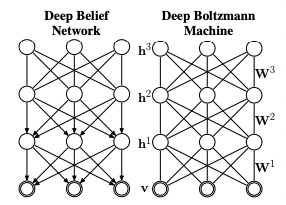

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((60000,-1)).astype("float32") / 255
X_test = X_test.reshape((10000,-1)).astype("float32") / 255

X_train, X_validation,y_train,  y_validation = train_test_split(X_train, y_train, test_size = 10000, random_state = 2023)
y_train = keras.utils.to_categorical(y_train, 10)
y_validation = keras.utils.to_categorical(y_validation, 10)
y_test = keras.utils.to_categorical(y_test, 10)

De **scikit-learn** implementatie is relatief makkelijk achter elkaar te zetten en te trainen.

In [3]:
hidden_sizes = [700, 600, 500, 500]
inp = X_train
RBMs = []
for size in hidden_sizes:
    rbm = BernoulliRBM(size, learning_rate = 1.0, batch_size = 200, n_iter = 100, random_state = 2023)
    inp = rbm.fit_transform(inp)
    RBMs.append(rbm)
    print(f'Model (size = {size}) done!')

In [4]:
#with open('DBN.pickle', 'wb') as file:
#    pickle.dump(RBMs, file)

In [5]:
with open('DBN.pickle', 'rb') as file:
    RBMs = pickle.load(file)

### Voorbeeld: MNIST data generatie

Door een oorpronkelijk beeld nu aan de *visible* laag aan te bieden, de *hidden* lagen een voor een te samplen, en dan terug te gaan en de *visible* lagen te samplen, genereren we nieuwe afbeeldingen gerelateerd aan het origineel.

In [6]:
def maakplot(n, seed):
    rng = np.random.RandomState(seed)
    img = X_train[n]
    plt.figure(figsize = (50,20))
    plt.subplot(2,5,1)
    plt.imshow(img.reshape(28,28), cmap='gray')
    plt.axis('off')
    for i in range(9):
        x = img.reshape(1,-1)
        for rbm in RBMs:
            x = rbm._sample_hiddens(x,rng)
        for rbm in reversed(RBMs):
            x = rbm._sample_visibles(x,rng)
        plt.subplot(2,5,i+2)
        plt.imshow(x.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.show()
    
interactive(maakplot, n=(0,20), seed = (0,20))

interactive(children=(IntSlider(value=10, description='n', max=20), IntSlider(value=10, description='seed', ma…

### Voorbeeld: MNIST unsupervised pre-training

We kunnen de gewichten en bias van een DBN gebruiken om een neuraal netwerk te initialiseren. Dit is een vorm van *transfer learning*.

In [6]:
inputs = keras.Input(shape=(28*28,))
x = layers.Dense(hidden_sizes[0], activation='sigmoid')(inputs)
x = layers.Dense(hidden_sizes[1], activation='sigmoid')(x)
x = layers.Dense(hidden_sizes[2], activation='sigmoid')(x)
x = layers.Dense(hidden_sizes[3], activation='sigmoid')(x)
outputs = layers.Dense(10, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)
for i in range(4):
    model.layers[i+1].set_weights([RBMs[i].components_.transpose(), RBMs[i].intercept_hidden_])
    model.layers[i+1].trainable = False
model.summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 700)               549500    
                                                                 
 dense_1 (Dense)             (None, 600)               420600    
                                                                 
 dense_2 (Dense)             (None, 500)               300500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1,526,110
Trainab

2023-01-11 16:47:37.696854: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-11 16:47:37.696951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = 'accuracy')

In [8]:
hist = model.fit(X_train[:5000,:], 
                 y_train[:5000],
                 validation_data = (X_validation, y_validation),
                 epochs = 30)

Epoch 1/30


2023-01-11 16:47:37.815538: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-11 16:47:37.986586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 2.1244 - accuracy: 0.3958

2023-01-11 16:47:39.483636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 3s 18ms/step - loss: 2.1244 - accuracy: 0.3958 - val_loss: 1.9713 - val_accuracy: 0.6131
Epoch 2/30
157/157 [==============================] - 3s 17ms/step - loss: 1.8354 - accuracy: 0.7024 - val_loss: 1.7172 - val_accuracy: 0.7342
Epoch 3/30
157/157 [==============================] - 3s 17ms/step - loss: 1.6040 - accuracy: 0.7542 - val_loss: 1.5160 - val_accuracy: 0.7368
Epoch 4/30
157/157 [==============================] - 3s 17ms/step - loss: 1.4193 - accuracy: 0.7550 - val_loss: 1.3522 - val_accuracy: 0.7528
Epoch 5/30
157/157 [==============================] - 3s 17ms/step - loss: 1.2732 - accuracy: 0.7612 - val_loss: 1.2249 - val_accuracy: 0.7528
Epoch 6/30
157/157 [==============================] - 3s 17ms/step - loss: 1.1563 - accuracy: 0.7602 - val_loss: 1.1214 - val_accuracy: 0.7540
Epoch 7/30
157/157 [==============================] - 3s 16ms/step - loss: 1.0619 - accuracy: 0.7654 - val_loss: 1.0393 - val_accuracy: 0.7579
Epoch 8/30

- We doen alsof we van alleen de eerste 5000 plaatjes de labels kennen.
- De gewichten van de eerste lagen komen ui het DBN, en zijn *unsupervised* getrained. Dezen worden vervolgens bevroren.
- De 5010 gewichten van de laatste laag worden *supervised* getrained.
- Eventueel kunnen we hierna nog het hele netwerk wat *fine-tunen*.

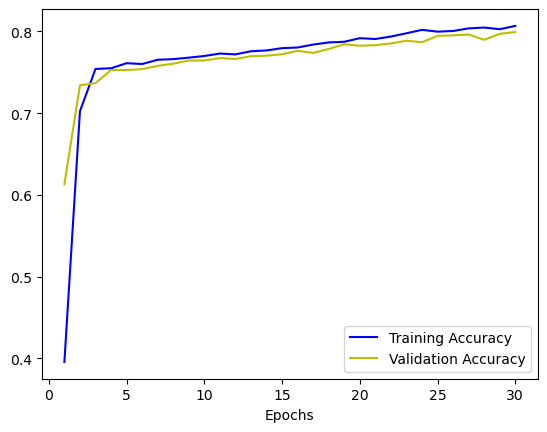

In [13]:
plt.plot(np.arange(1,31), 'accuracy','b-', data = hist.history, label = 'Training Accuracy')
plt.plot(np.arange(1,31), 'val_accuracy','y-', data = hist.history, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()